Some prelims:

In [1]:
IN_COLAB = 'google.colab' in str(get_ipython())
TRAIN = True

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    %cd /content/drive/MyDrive/Documents/HLML/abstracts/local_tz/datasets/

Mounted at /content/drive
/content/drive/MyDrive/Documents/HLML/abstracts/local_tz/datasets


In [ ]:
!pip install feedparser
import pandas as pd
import feedparser
import numpy as np 
import matplotlib.pyplot as plt 
from collections import Counter

!python -m spacy download en_core_web_lg
import spacy
import en_core_web_lg
nlp = en_core_web_lg.load()

!pip install python-igraph==0.8.3
!apt install libcairo2-dev pkg-config python3-dev
!pip install python-igraph leidenalg cairocffi

import igraph as ig

First we load the data file, and do the usual processing steps to tokenize and build the vocabulary. 

In [5]:
master_df = pd.read_pickle("arxiv_system_10000.pkl")

titles = master_df.title.str.replace(r'\n', ' ')
titles = titles.str.replace('  ', '')

doc=[nlp.tokenizer(text.lower().strip()) for text in titles]

In [15]:
## manually constructing vocabulary
class Vocabulary:
    PAD_token = 0   # Used for padding short sentences
    BOS_token = 1   # Beginning-of-sentence token
    EOS_token = 2   # End-of-sentence token

    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {}
        self.num_words = 0
        self.num_sentences = 0
        self.longest_sentence = 0

        ## add PAD, BOS, EOS tokens:
        self.word2index['<PAD>'] = self.num_words
        self.word2count['<PAD>'] = 1
        self.index2word[self.num_words] = '<PAD>'
        self.num_words += 1

        self.word2index['<BOS>'] = self.num_words
        self.word2count['<BOS>'] = 1
        self.index2word[self.num_words] = '<BOS>'
        self.num_words += 1

        self.word2index['<EOS>'] = self.num_words
        self.word2count['<EOS>'] = 1
        self.index2word[self.num_words] = '<EOS>'
        self.num_words += 1

    def add_word(self, word):
        if word not in self.word2index:
            # First entry of word into vocabulary
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            # Word exists; increase word count
            self.word2count[word] += 1
            
    def add_sentence(self, sentence):
        sentence_len = 0 
        for word in [token.text for token in sentence]:
            sentence_len += 1
            self.add_word(word)
        if sentence_len > self.longest_sentence:
            self.longest_sentence = sentence_len
        self.num_sentences += 1
        self.word2count['<PAD>'] += 1
        self.word2count['<BOS>'] += 1

    def to_word(self, index):
        return self.index2word[index]

    def to_index(self, word):
        return self.word2index[word]

In [16]:
voc=Vocabulary('abstracts')
for sent in doc:
  voc.add_sentence(sent)
  
Input_list=[]
for sample in range(len(doc)):
  Input_list.append([voc.to_index("<BOS>")]+[voc.to_index(token.text) for token in doc[sample]]+[voc.to_index("<EOS>")])

From here, we are interested in all the instances of token -> next_token. We represent these as (token, next_token) tuples, and tally the frequencies that each of these tuples appear in the full dataset. 

To do: we should be looking at the training set only, for the patterns that appear at the generations step. 

In [17]:
tok_pair_list = []
for i in range(len(Input_list)):
  sentence = Input_list[i]
  for j in range(len(sentence)-1):
    tok_pair_list.append(tuple([sentence[j], sentence[j+1]]))

In [ ]:
tok_pair_counter = Counter(tok_pair_list)

In [131]:
df = pd.DataFrame.from_dict(tok_pair_counter, orient='index').reset_index()
df = df.rename(columns={'index':'tok pair', 0:'count'})
df[['tok1', 'tok2']] = pd.DataFrame(df['tok pair'].tolist(), index=df.index)
df = df[['tok1', 'tok2', 'count']]
df.head()

tok1  tok2  count
0     1     3      4
1     3     4      1
2     4     5      1
3     5     6      4
4     6     7     21

We can represent these tok1 -> tok2 transitions as a directed graph. For visualization, I want the size of each vertex (token) to reflect the frequency of the token in the data set, and the size of each edge to reflect how often tok1 is followed by tok2. 

In [27]:
word_freqs = [voc.word2count[voc.to_word(i)] for i in range(voc.num_words)]

In [133]:
tuples = [tuple(x) for x in df.values]
g = ig.Graph.TupleList(tuples, directed=True, edge_attrs=["weight"])
g.vs['size'] = 0.01*np.array(word_freqs)
g.es['color'] = 'grey'
g.vs['color'] = 'white'
vseq = g.vs["name"]
g.vs['name'] = [voc.to_word(i) for i in vseq]
g.vs["label"] = g.vs["name"]
g.vs["label_size"] = 6
g.es["width"] = 0.01*np.array(g.es["weight"])
g.es["arrow_size"] = 0.5

Even without visualizing, we can look at all the possible transitions from a token, and how many times each of these occur within the dataset. 

In [123]:
v = g.vs[3247]
print(v["name"])
for u in v.successors():
  print(u["name"], g.es[g.get_eid(v, u, error=False)]['weight'])

understanding
of 4
systems 1
<EOS> 2
complex 1
system 3
and 1
the 3
quantum 1
error 1
early 1
fuchsia 1
utility 1


In [125]:
## quick check for accuracy of the above output
tup = (voc.to_index("<BOS>"), voc.to_index("understanding"))
tok_pair_counter[tup]

9

Half of the tokens appear only in one context (probably just one title), with only one in-neighbour and one out-neighbour

In [134]:
g1 = g.subgraph([v for v in g.vs() if len(g.neighbors(v))==2])
print("Fraction of tokens with only 2 neighbours: ", g1.vcount()/g.vcount())
ig.plot(g1)

Fraction of tokens with only 2 neighbours:  0.5197415649676956


Here are the vertices that are the most densely connected. The keyword I used for my arxiv search was 'system', so unsurprisingly, that is the largest vertex.

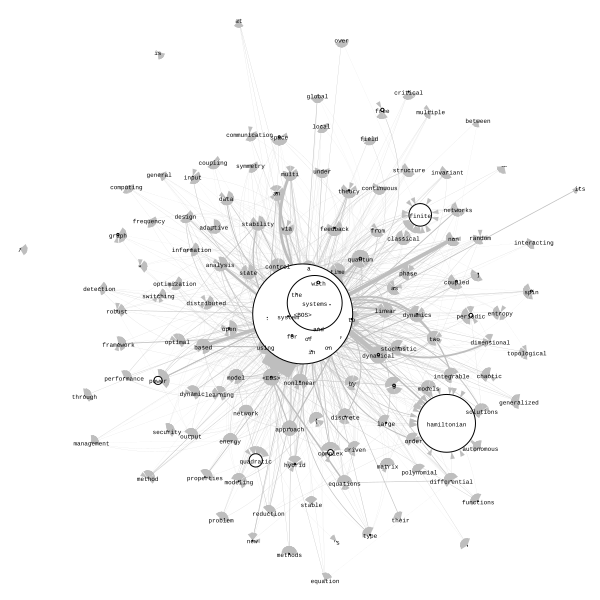

In [135]:
gl = g.subgraph([v for v in g.vs() if len(g.neighbors(v))>=70])
ig.plot(gl)